In [1]:
import random
from copy import deepcopy
from math import ceil
import numpy as np
import pandas as pd


class Genome:
    genome = []
    route_distance = 0
    distance_map = []

    def __init__(self, number_of_cities, starting_city, distance_map, genome_list=[]):
        self.distance_map = deepcopy(distance_map)
        self.starting_city = starting_city
        self.number_of_cities = number_of_cities
        if len(genome_list) == 0:
            self.genome = self.random_result()
        else:
            self.genome = deepcopy(genome_list)
        self.route_distance = self.calculate_route_distance()
        self.fitness = 1 / float(self.route_distance)

    def random_result(self):
        cityList = list(range(self.starting_city + 1, self.number_of_cities))
        route = random.sample(cityList, len(cityList))
        return route

    def calculate_route_distance(self):
        dist = 0
        current_city = self.starting_city
        for gene in self.genome:
            dist_bef = dist
            dist = dist + self.distance_map[current_city][gene]
            current_city = gene

        dist = dist + self.distance_map[current_city][self.starting_city]
        return dist


def selection(pop, rate):
    size = rate * len(pop)
    weights = []
    sum_fitness = sum(genome.fitness for genome in pop)
    for genome in pop:
        weights.append(genome.fitness / sum_fitness)
    return random.choices(pop, weights, k=int(ceil(size)))


def best_of_pop(pop):
    best_fit = max([gene.fitness for gene in pop])
    for i in range(0, len(pop)):
        if pop[i].fitness == best_fit:
            return pop[i]


def read_txt(file_name):
    distances = []
    temp = []
    f = open(file_name, "r")
    for line in f:
        tt = line.split("\n")[0].split("\t")
        for index in range(0, len(tt)):
            add = int(tt[index])
            if add == 0:
                add = 99999
            temp.append(add)
        distances.append(np.array(temp))
        temp.clear()
    return distances


def make_crossover(parents, children):
    crossover_breakpoint = random.randint(0, len(parents[0].genome))
    parent1Genome = deepcopy(parents[0].genome)
    parent2Genome = deepcopy(parents[1].genome)
    for i in range(0, crossover_breakpoint):
        newVal = parent2Genome[i]
        index = parent1Genome.index(newVal)
        parent1Genome[index], parent1Genome[i] = \
            parent1Genome[i], parent1Genome[index]
    children.append(Genome(parents[0].number_of_cities,
                           parents[0].starting_city,
                           parents[0].distance_map,
                           parent1Genome))
    for j in range(crossover_breakpoint, len(parents[0].genome)):
        newVal = parent1Genome[j]
        index = parent2Genome.index(newVal)
        parent2Genome[index], parent2Genome[j] = \
            parent2Genome[j], parent2Genome[index]
    children.append(Genome(parents[0].number_of_cities,
                           parents[0].starting_city,
                           parents[0].distance_map,
                           parent2Genome))
    return children


def choose_couple(parent_pop):
    return random.choices(parent_pop, k=2)


def create_generation(generation, parents, children):
    generation.clear()
    generation = deepcopy(parents)
    generation.extend(children)
    return generation


def run_ga(pop_size,max_iter_size,max_stalling,selection_rate,filename):
    # parameters: //Assuming route should start from 0.

    distance_map = read_txt(filename)
    pop = []
    for i in range(0, pop_size):
        pop.append(Genome(len(distance_map), 0, distance_map))
    #######
    generation = []
    generations = []
    children = []
    parents = []
    best_of_generations = []
    follow_best = []
    stalling = 0
    best_global = deepcopy(best_of_pop(pop))
    print("initial pop best:",best_global.genome, best_global.fitness,
          best_global.route_distance)
    generations.append(pop)
    for i in range(0, max_iter_size):
        parent_pop = selection(pop, selection_rate)
        children_count = int(pop_size - (pop_size * selection_rate))
        for j in range(0, children_count):
            parents = choose_couple(parent_pop)
            children = make_crossover(parents, children)
            generation = create_generation(generation, parents, children)
        best_local = deepcopy(best_of_pop(generation))
        follow_best.append(deepcopy(best_local))
        if best_global.fitness < best_local.fitness:
            best_global = deepcopy(best_local)
        generations.append(generation)

    print("after iters. best:",best_global.genome, best_global.fitness,
          best_global.route_distance)
    return follow_best

In [2]:
pop_size = 29
max_iter_size = 1000
max_stalling = 500
selection_rate = 0.2
filename = "src/29_cities.txt"

import timeit

start = timeit.default_timer()
gens_try1=run_ga(pop_size,max_iter_size,max_stalling,selection_rate,filename)
stop = timeit.default_timer()
print('Time: ', stop - start,'sec')  

initial pop best: [27, 11, 7, 6, 18, 8, 4, 19, 17, 22, 12, 25, 28, 14, 10, 21, 13, 20, 23, 9, 16, 1, 3, 26, 5, 15, 24, 2] 0.0002011667672500503 4971
after iters. best: [27, 11, 7, 6, 18, 8, 4, 19, 17, 22, 12, 25, 28, 14, 10, 21, 13, 16, 9, 5, 15, 23, 20, 1, 3, 24, 26, 2] 0.00022716946842344388 4402
Time:  33.306286403 sec


In [3]:
data = {'Best Routes': [gens_try1[i].genome for i in range(0, len(gens_try1))]}
df = pd.DataFrame(data)
df['Route Distance'] = [gens_try1[i].route_distance for i in range(0, len(gens_try1))]
df['fitness'] = [gens_try1[i].fitness for i in range(0, len(gens_try1))]
print(df)

                                           Best Routes  Route Distance  \
0    [5, 9, 22, 26, 8, 21, 17, 11, 13, 27, 1, 4, 2,...            5648   
1    [22, 26, 28, 7, 11, 24, 10, 14, 3, 6, 2, 25, 2...            5215   
2    [22, 26, 28, 7, 11, 24, 10, 14, 3, 6, 2, 25, 2...            5215   
3    [27, 11, 7, 6, 18, 8, 4, 19, 17, 22, 12, 25, 2...            4877   
4    [27, 11, 7, 6, 18, 8, 4, 19, 17, 22, 12, 25, 2...            4877   
..                                                 ...             ...   
995  [27, 11, 7, 6, 18, 8, 4, 19, 17, 22, 12, 25, 2...            4402   
996  [27, 11, 7, 6, 18, 8, 4, 19, 17, 22, 12, 25, 2...            4402   
997  [27, 11, 7, 6, 18, 8, 4, 19, 17, 22, 12, 25, 2...            4402   
998  [27, 11, 7, 6, 18, 8, 4, 19, 17, 22, 12, 25, 2...            4402   
999  [27, 11, 7, 6, 18, 8, 4, 19, 17, 22, 12, 25, 2...            4402   

      fitness  
0    0.000177  
1    0.000192  
2    0.000192  
3    0.000205  
4    0.000205  
..        ...  

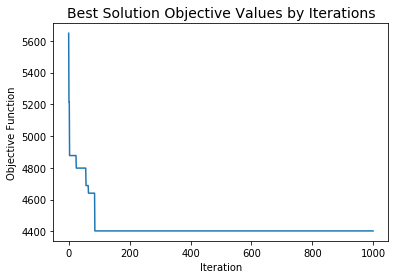

In [5]:
import matplotlib.pyplot as plt

plt.title('Best Solution Objective Values by Iterations',fontsize = 14)
plt.plot(df['Route Distance'])
plt.xlabel('Iteration',fontsize = 10)
plt.ylabel('Objective Function',fontsize = 10)
plt.show()